<a href="https://colab.research.google.com/github/yashkathe/Deep-Learning-with-PyTorch/blob/master/04_NonLinear_Activation_Functions_Multiclass_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Class Classification Problem

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png" height="350">

| Hyperparameter                | Binary Classification                                                             | Multiclass classification                                         |
|-------------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------------|
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                                     |
| Hidden layer(s)               | Problem specific, minimum = 1, maximum = unlimited                                | Same as binary classification                                     |
| Neurons per hidden layer      | Problem specific, generally 10 to 512                                             | Same as binary classification                                     |
| Output layer shape (out_features) | 1 (one class or the other)                                                       | 1 per class (e.g. 3 for food, person or dog photo)                 |
| Hidden layer activation       | Usually ReLU (rectified linear unit) but can be many others                       | Same as binary classification                                     |
| Output activation             | Sigmoid (torch.sigmoid in PyTorch)                                                | Softmax (torch.softmax in PyTorch)                                |
| Loss function                 | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                 | Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)               |
| Optimizer                     | SGD (stochastic gradient descent), Adam (see torch.optim for more options)        | Same as binary classification                                     |


## Create a toy multi class data set

In [184]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### Setting Hyper parameters for data creation

In [185]:
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=20

In [186]:
# Create multi class data
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std= 1, # give clusters a little shake up
                            random_state=RANDOM_SEED
                            )

### Turn data into tensors

In [187]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

### Split train test split

In [188]:
x_blob_train, x_blob_test, y_blob_train, y_blob_test =  train_test_split(x_blob,
                                                                          y_blob,
                                                                          test_size=0.2,
                                                                          random_state = RANDOM_SEED)

### Plot the data

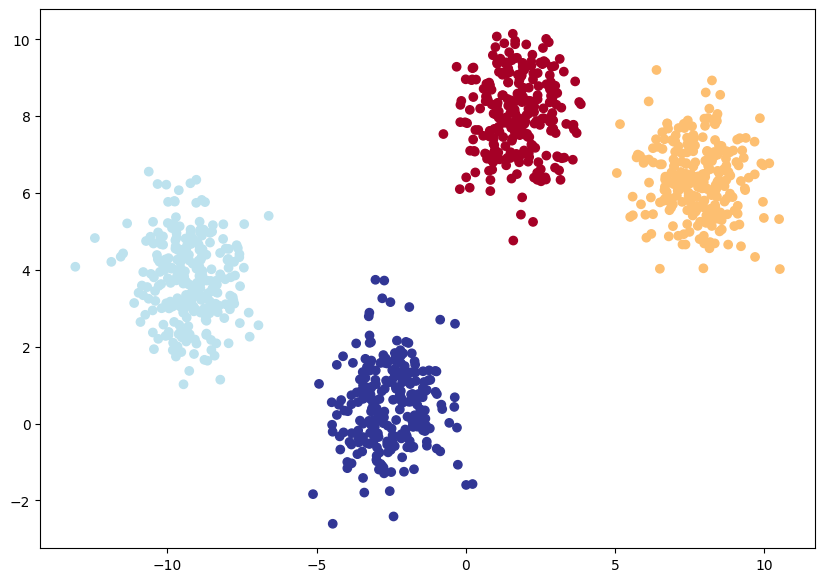

In [189]:
plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


## Calculate accuracy

Out of 100 examples, what percentage does our model get right?


In [190]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # Counts how many predictions match the true labels and converts the total to a Python number
  acc = (correct/len(y_pred)) * 100
  return acc

## Setup Device Agnostic Code

In [191]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Building Multiclass model


In [192]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """
    Args:
      input_features = Number of input features to model
      output_features = Number of output features
      hidden_units = Number of hidden units between layers (default 8)
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# create an instance of our model

model_0 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [193]:
x_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([3, 2, 2, 2, 2]))

In [194]:
# why out_features 4 ?
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

## Create a Loss Function and Optimizer

In [195]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## Getting prediciton probablities

in order to evaluate and train and test our model, we need to convert our model's logit to prediction probablities and then to prediction labels

`Logits (raw output) -> Pred probs (use torch.softmax) -> Pred labels (take argmax of prediction probablities) `

In [196]:
# Get raw outputs from moedel (logits)

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_blob_test.to(device))

y_logits[:1]

tensor([[-0.0131, -0.7610, -0.3924, -0.0729]], device='cuda:0')

In [197]:
# we need to get this format
y_blob_test[:10]

tensor([2, 0, 2, 3, 3, 1, 2, 0, 3, 1])

### Convert model's logit output to prediction probablities

In [198]:
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0131, -0.7610, -0.3924, -0.0729],
        [-0.5081, -1.1918, -1.3812, -0.7054],
        [-0.0294, -0.7977, -0.4286, -0.0821],
        [ 0.2286, -0.2470,  0.1256,  0.0450],
        [ 0.1840, -0.3197,  0.0472,  0.0398]], device='cuda:0')
tensor([[0.3226, 0.1527, 0.2208, 0.3039],
        [0.3645, 0.1840, 0.1522, 0.2992],
        [0.3243, 0.1504, 0.2176, 0.3077],
        [0.2980, 0.1852, 0.2688, 0.2480],
        [0.2992, 0.1808, 0.2610, 0.2590]], device='cuda:0')


In [199]:
# the output is summing upto 1

torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

tensor([[0.2043, 0.2961, 0.3026, 0.1970])

What this is giving is probablities for each class


|  1   |   2   |   3   |   4   |
|------|-------|-------|-------|
|0.2043| 0.2961| 0.3026| 0.1970|

In [200]:
torch.max(y_pred_probs[0])

tensor(0.3226, device='cuda:0')

how do we know we index it is ?
`argmax`

In [201]:
torch.argmax(y_pred_probs[0])

tensor(0, device='cuda:0')

### Convert model's probablities to labels

In [202]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

In [203]:
y_blob_test

tensor([2, 0, 2, 3, 3, 1, 2, 0, 3, 1, 3, 2, 1, 1, 2, 0, 1, 1, 3, 3, 3, 1, 2, 3,
        3, 3, 0, 2, 2, 1, 1, 0, 3, 3, 2, 0, 3, 0, 2, 3, 1, 2, 0, 2, 1, 2, 3, 2,
        2, 0, 1, 1, 0, 3, 2, 0, 1, 0, 2, 3, 3, 0, 0, 2, 2, 3, 2, 2, 1, 2, 1, 1,
        0, 2, 1, 3, 3, 3, 0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 2, 3, 0, 3, 0, 2, 0,
        0, 3, 2, 3, 0, 1, 1, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 0, 1,
        2, 2, 3, 1, 1, 0, 3, 0, 0, 2, 0, 0, 0, 3, 1, 1, 2, 0, 0, 0, 1, 1, 2, 3,
        0, 0, 3, 0, 1, 3, 1, 3, 3, 1, 2, 0, 3, 3, 1, 3, 2, 2, 0, 0, 0, 1, 0, 0,
        1, 0, 2, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 2, 3, 2, 0, 2, 3,
        2, 3, 3, 2, 2, 0, 3, 1])

## Training and Testing Loop

In [204]:
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put data to target device
x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

In [205]:
# set number of epochs
epochs = 301

for epoch in range(epochs):
    ### Training
    model_0.train()

    y_logits = model_0(x_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():

      # 1. Forward pass
      test_logits = model_0(x_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.18584, Acc: 49.62% | Test Loss: 1.07918, Test Acc: 48.00%
Epoch: 10 | Loss: 0.72490, Acc: 74.62% | Test Loss: 0.70255, Test Acc: 76.50%
Epoch: 20 | Loss: 0.46872, Acc: 74.62% | Test Loss: 0.44267, Test Acc: 76.50%
Epoch: 30 | Loss: 0.37469, Acc: 75.38% | Test Loss: 0.35379, Test Acc: 77.00%
Epoch: 40 | Loss: 0.32021, Acc: 79.50% | Test Loss: 0.30252, Test Acc: 84.50%
Epoch: 50 | Loss: 0.28106, Acc: 84.88% | Test Loss: 0.26536, Test Acc: 89.50%
Epoch: 60 | Loss: 0.25045, Acc: 90.88% | Test Loss: 0.23609, Test Acc: 93.00%
Epoch: 70 | Loss: 0.22541, Acc: 94.25% | Test Loss: 0.21205, Test Acc: 95.50%
Epoch: 80 | Loss: 0.20434, Acc: 96.38% | Test Loss: 0.19182, Test Acc: 96.00%
Epoch: 90 | Loss: 0.18627, Acc: 98.12% | Test Loss: 0.17447, Test Acc: 98.00%
Epoch: 100 | Loss: 0.17057, Acc: 99.12% | Test Loss: 0.15944, Test Acc: 99.50%
Epoch: 110 | Loss: 0.15680, Acc: 99.38% | Test Loss: 0.14629, Test Acc: 99.50%
Epoch: 120 | Loss: 0.14467, Acc: 99.62% | Test Loss: 0.13474, T

## Making and Evaluating Predictions

In [206]:
# make predictions (logits)

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(x_blob_test)

In [207]:
# Convert logits to prediction probablities

y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred_probs[:5]

tensor([[1.1497e-08, 2.3247e-10, 9.6502e-01, 3.4985e-02],
        [9.9717e-01, 2.5821e-03, 2.7414e-11, 2.4527e-04],
        [3.5359e-09, 5.8958e-11, 9.7650e-01, 2.3503e-02],
        [2.4419e-02, 8.8096e-03, 6.4051e-02, 9.0272e-01],
        [2.9115e-03, 6.1682e-04, 1.7185e-01, 8.2462e-01]], device='cuda:0')

In [208]:
y_blob_test[:5]

tensor([2, 0, 2, 3, 3], device='cuda:0')

In [209]:
# Pred probs to labels

y_pred_probs.argmax()

y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds[:5]

tensor([2, 0, 2, 3, 3], device='cuda:0')

## Visualize the prediction made by the model

In [210]:
import requests
from pathlib import Path

In [211]:

# Download helper function from github repository (raw version)

if Path("helper_functions.py").is_file():
  print("helper function exists already, skipping downloads")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper function exists already, skipping downloads


In [212]:
# Import functions from downloaded file

from helper_functions import plot_predictions, plot_decision_boundary

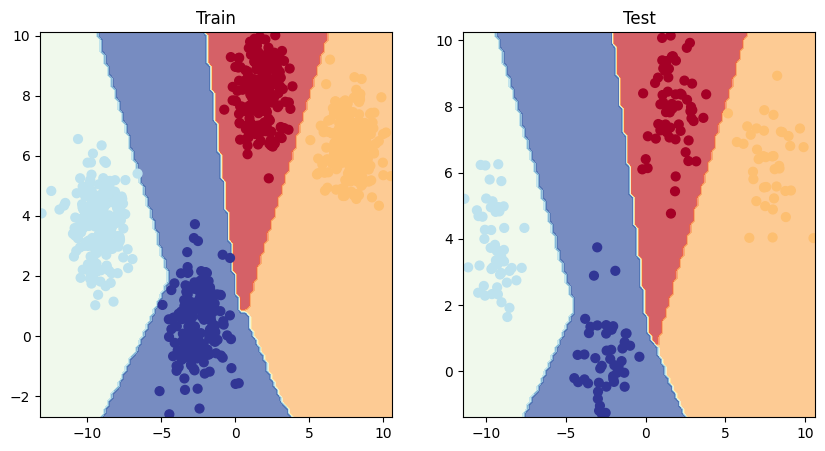

In [213]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(model_0, x_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_blob_test, y_blob_test)


## A few more classification metrics

| Metric Name         | Definition                                                                                                                                 | Code                                                      |
|---------------------|--------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------|
| **Accuracy**        | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct.                  | `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()` |
| **Precision**       | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | `torchmetrics.Precision()` or `sklearn.metrics.precision_score()` |
| **Recall**          | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | `torchmetrics.Recall()` or `sklearn.metrics.recall_score()` |
| **F1-score**        | Combines precision and recall into one metric. 1 is best, 0 is worst.                                                                      | `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()`   |
| **Confusion Matrix**| Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagonal line). | `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()` |
| **Classification Report** | Collection of some of the main classification metrics such as precision, recall, and f1-score.                                        | `sklearn.metrics.classification_report()`                  |


In [214]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

In [215]:
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(1., device='cuda:0')